In [56]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop','reggae','rock']
dataset = []

In [58]:
output_dir = "spectrograms"
os.makedirs(output_dir, exist_ok=True)


In [59]:
for genre in genres:
    folder = f"Data/genres_original/{genre}"
    genre_dir = os.path.join(output_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)
    
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            save_path = os.path.join(genre_dir, filename.replace(".wav", ".png"))

            # Skip if already processed
            if os.path.exists(save_path):
                print(f"⏭️ Skipped (already exists): {filename}")
                continue
            
            try:
                y, sr = librosa.load(file_path, duration=30)

                # Compute STFT (normal spectrogram)
                D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))  # magnitude
                S_dB = librosa.amplitude_to_db(D, ref=np.max)  # convert to dB scale

                # Save as image
                plt.figure(figsize=(3,3))
                librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='linear')
                plt.axis('off')
                
                plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
                plt.close()

                print(f"✅ Success: {filename}")

            except Exception as e:
                print(f"❌ Failed: {filename}")


⏭️ Skipped (already exists): blues.00000.wav
⏭️ Skipped (already exists): blues.00001.wav
⏭️ Skipped (already exists): blues.00002.wav
⏭️ Skipped (already exists): blues.00003.wav
⏭️ Skipped (already exists): blues.00004.wav
⏭️ Skipped (already exists): blues.00005.wav
⏭️ Skipped (already exists): blues.00006.wav
⏭️ Skipped (already exists): blues.00007.wav
⏭️ Skipped (already exists): blues.00008.wav
⏭️ Skipped (already exists): blues.00009.wav
⏭️ Skipped (already exists): blues.00010.wav
⏭️ Skipped (already exists): blues.00011.wav
⏭️ Skipped (already exists): blues.00012.wav
⏭️ Skipped (already exists): blues.00013.wav
⏭️ Skipped (already exists): blues.00014.wav
⏭️ Skipped (already exists): blues.00015.wav
⏭️ Skipped (already exists): blues.00016.wav
⏭️ Skipped (already exists): blues.00017.wav
⏭️ Skipped (already exists): blues.00018.wav
⏭️ Skipped (already exists): blues.00019.wav
⏭️ Skipped (already exists): blues.00020.wav
⏭️ Skipped (already exists): blues.00021.wav
⏭️ Skipped

C:\Users\mazin\AppData\Local\Temp\ipykernel_15908\1811498183.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
C:\Users\mazin\AppData\Local\Programs\Python\Python313\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [60]:
import tensorflow as tf

img_height, img_width = 128, 128
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "spectrograms",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "spectrograms",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [61]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [62]:
#Divides every pixel by 255
normalization = tf.keras.layers.Rescaling(1/255.0)

def preprocess(image, label):
    image = normalization(image)
    return image, label

#Applies the normalization without affecting the labels
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [63]:
from tensorflow.keras import layers, models, Input

num_classes = len(genres)  # 10 genres

model = models.Sequential([
    Input(shape=(128,128,3)),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,849,002 (7.05 MB)

 Trainable params: 1,849,002 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
history = model.fit(train_ds,validation_data = val_ds, epochs=20)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1850 - loss: 2.3492 - val_accuracy: 0.1759 - val_loss: 2.1659
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2562 - loss: 2.0135 - val_accuracy: 0.2613 - val_loss: 2.0684
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2975 - loss: 1.8808 - val_accuracy: 0.3116 - val_loss: 1.8899
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3325 - loss: 1.8109 - val_accuracy: 0.3518 - val_loss: 1.7874
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4087 - loss: 1.6321 - val_accuracy: 0.3668 - val_loss: 1.7221
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4500 - loss: 1.5673 - val_accuracy: 0.3819 - val_loss: 1.7051
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4588 - loss: 1.4880 - val_accuracy: 0.3970 - val_loss: 1.6111
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5075 - loss: 1.3651 - val_accuracy: 0.4171 - v

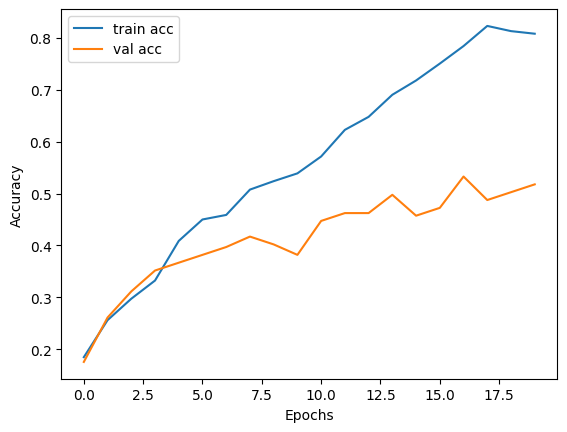

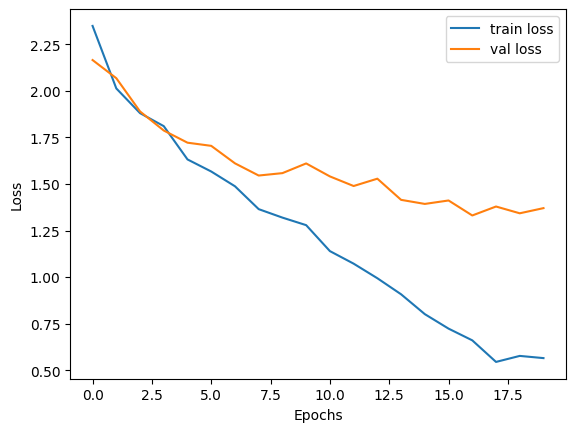

In [68]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [66]:
y_pred_probs = model.predict(val_ds) 
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.concatenate([y for x, y in val_ds], axis=0)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


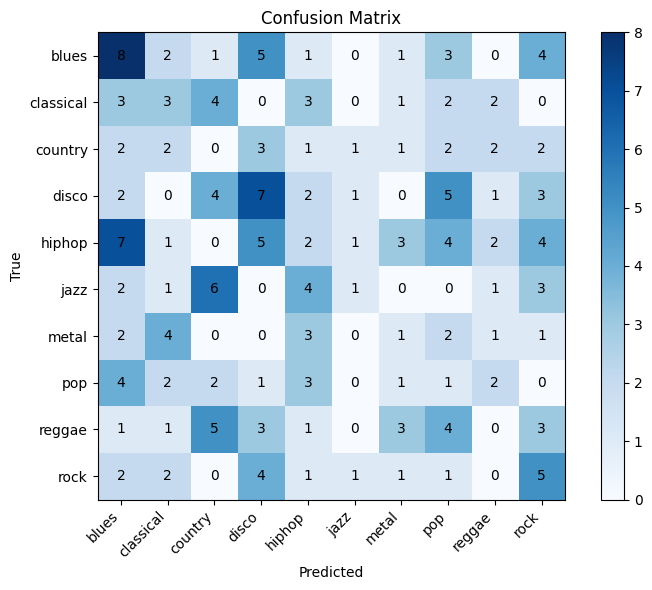

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, cmap="Blues")

# add colorbar
plt.colorbar(im)

# show labels on axes
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

# write numbers inside boxes
for i in range(len(cm)):
    for j in range(len(cm[i])):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
